In [1]:
import os, sys, pathlib

REPO_URL = "https://github.com/UmerSR/Connect-Four-RL.git"
WORKSPACE = "/content/Connect-Four-RL"

if not os.path.exists(WORKSPACE):
    !git clone $REPO_URL $WORKSPACE
else:
    %cd $WORKSPACE
    !git pull --ff-only

%cd $WORKSPACE/rl_connect4
sys.path.insert(0, WORKSPACE)
print("CWD:", os.getcwd())

Cloning into '/content/Connect-Four-RL'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 118 (delta 7), reused 26 (delta 6), pack-reused 87 (from 1)
Receiving objects: 100% (118/118), 56.85 MiB | 13.23 MiB/s, done.
Resolving deltas: 100% (32/32), done.
/content/Connect-Four-RL/rl_connect4
CWD: /content/Connect-Four-RL/rl_connect4


In [2]:
!pip install -q stable-baselines3[extra] sb3-contrib gymnasium pygame numpy torch pandas matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 12.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.8 MB/s eta 0:00:0000:

In [34]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # Progress bar for notebooks

# Dense-reward env wrapper to match (3,6,7) obs and action mask
from envs.connect_four_env import ConnectFourEnv as BaseEnv
from gymnasium import spaces

class ConnectFourEnv(BaseEnv):
    def __init__(self):
        super().__init__()
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, self.rows, self.cols), dtype=np.float32)

    def _convert_obs(self):
        base_obs = super()._get_obs()
        cur_plane = base_obs['observation'][..., 0]
        opp_plane = base_obs['observation'][..., 1]
        legal_mask = base_obs['action_mask'].astype(np.float32)
        legal_layer = np.tile(legal_mask, (self.rows, 1))
        obs = np.stack([cur_plane, opp_plane, legal_layer], axis=0).astype(np.float32)
        info = {'legal_moves': legal_mask, 'turn': self.current_player + 1}
        return obs, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        _obs, _info = super().reset(seed=seed, options=options)
        return self._convert_obs()

    def step(self, action):
        _, reward, terminated, truncated, info = super().step(int(action))
        obs, mask_info = self._convert_obs()
        info.update(mask_info)
        return obs, reward, terminated, truncated, info

# Detect Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running on: {device}')

Running on: cuda


In [35]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        # Input shape: (Batch, 3, 6, 7)
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(3, 32, kernel_size=3, padding=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, kernel_size=3, padding=1)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, kernel_size=3, padding=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 6 * 7, 512)),
            nn.ReLU(),
        )

        # Determine action space size
        # If envs is a vector env, use single_action_space
        # If envs is a normal env, use action_space
        if hasattr(envs, "single_action_space"):
            n_actions = envs.single_action_space.n
        else:
            n_actions = envs.action_space.n

        self.actor = layer_init(nn.Linear(512, n_actions), std=0.01)
        self.critic = layer_init(nn.Linear(512, 1), std=1)

    def get_value(self, x):
        return self.critic(self.network(x))

    def get_action_and_value(self, x, action=None, action_mask=None):
        hidden = self.network(x)
        logits = self.actor(hidden)

        if action_mask is not None:
            # Mask invalid moves
            logits = torch.where(action_mask == 1, logits, torch.tensor(-1e8).to(x.device))

        probs = Categorical(logits=logits)

        if action is None:
            action = probs.sample()

        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)

In [36]:
import copy
from collections import deque

def train_ppo_80_20(
    total_timesteps=2000000,
    pool_size=20,           # Keep last 20 versions
    pool_update_freq=50000, # Add to pool every 50k steps
    opponent_sample_rate=0.2, # 20% of games are against history
    learning_rate=2.5e-4,
    num_envs=16,            # Speed: Use all CPU cores
    num_steps=512,          # Speed: Larger GPU batches
    gamma=0.99,
    gae_lambda=0.95,
    clip_coef=0.2,
    ent_coef=0.03,          # Increased entropy for exploration
    seed=1
):
    print(f"--- Starting 80/20 Self-Play Training ({total_timesteps} steps) ---")
    
    # 1. Setup & Seeding
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Environment Setup
    # Note: Ensure make_env is defined if using multiprocessing, or use lambda for SyncVectorEnv
    # For robust multiprocessing, define make_env at top level.
    # Here assuming SyncVectorEnv or compatible wrapper is available.
    envs = AsyncVectorEnv([lambda: ConnectFourEnv() for _ in range(num_envs)])
    
    # Agent (The Learner)
    agent = Agent(envs).to(device)
    optimizer = optim.Adam(agent.parameters(), lr=learning_rate, eps=1e-5)
    
    # Opponent (The Ghost - used for history replay)
    opponent_net = Agent(envs).to(device)
    opponent_net.load_state_dict(agent.state_dict()) # Init as clone
    
    # History Pool
    pool = [copy.deepcopy(agent.state_dict())] # Start with initial weights
    
    # 2. Storage Buffers
    obs = torch.zeros((num_steps, num_envs) + envs.single_observation_space.shape).to(device)
    actions = torch.zeros((num_steps, num_envs) + envs.single_action_space.shape).to(device)
    logprobs = torch.zeros((num_steps, num_envs)).to(device)
    rewards = torch.zeros((num_steps, num_envs)).to(device)
    dones = torch.zeros((num_steps, num_envs)).to(device)
    values = torch.zeros((num_steps, num_envs)).to(device)
    masks = torch.zeros((num_steps, num_envs, envs.single_action_space.n)).to(device)
    
    # Training Mask: 1 if we train on this step, 0 if it was a Ghost move
    train_masks = torch.zeros((num_steps, num_envs)).to(device)

    # 3. Metric Tracking
    global_step = 0
    start_time = time.time()
    
    # Rolling windows for smooth plotting
    metric_window = 100
    ep_rewards_history = deque(maxlen=metric_window)
    ep_len_history = deque(maxlen=metric_window)
    
    # Accumulators for current episodes
    current_ep_rewards = np.zeros(num_envs)
    current_ep_lens = np.zeros(num_envs)
    
    # History for final plotting
    plots = {
        "avg_reward": [],
        "avg_length": [],
        "value_loss": [],
        "policy_loss": [],
        "entropy": []  # Added Entropy
    }

    # 4. Initialize State
    next_obs, info = envs.reset()
    next_obs = torch.Tensor(next_obs).to(device)
    next_done = torch.zeros(num_envs).to(device)
    next_mask = torch.as_tensor(np.stack(info["legal_moves"]), dtype=torch.float32).to(device)

    # Track which envs are in "History Mode" vs "Self-Play Mode"
    # We randomize this per game, but for simplicity, we randomize per rollout
    is_history_mode = np.random.rand(num_envs) < opponent_sample_rate

    batch_size = num_envs * num_steps
    num_updates = total_timesteps // batch_size
    
    # Loop
    for update in tqdm(range(1, num_updates + 1)):
        # Anneal Learning Rate
        frac = 1.0 - (update - 1.0) / num_updates
        lrnow = frac * learning_rate
        optimizer.param_groups[0]["lr"] = lrnow
        
        # --- POOL LOGIC ---
        # 1. Add current agent to pool
        if global_step % pool_update_freq < batch_size: # Approximate check
            if len(pool) >= pool_size:
                pool.pop(0) # Remove oldest
            pool.append(copy.deepcopy(agent.state_dict()))
        
        # 2. Pick a random opponent for the ghost network
        # (We update the ghost weights once per rollout for efficiency)
        if len(pool) > 0:
            random_weights = random.choice(pool)
            opponent_net.load_state_dict(random_weights)

        # --- ROLLOUT PHASE ---
        for step in range(num_steps):
            global_step += num_envs
            
            # Store observations
            obs[step] = next_obs
            dones[step] = next_done
            masks[step] = next_mask

            # GET ACTIONS
            with torch.no_grad():
                # 1. Ask Learner for actions (Standard)
                action_learner, logprob_learner, _, value_learner = agent.get_action_and_value(next_obs, action_mask=next_mask)
                
                # 2. Ask Ghost for actions (History)
                # We only need this if some envs are in history mode
                action_ghost, _, _, _ = opponent_net.get_action_and_value(next_obs, action_mask=next_mask)
            
            # COMPOSE FINAL ACTIONS
            # We assume Env flips perspective, so Agent always sees "My Turn".
            # To simulate history play, we simply replace the action with the Ghost's action 
            # for the environments marked as history mode, but we do this STOCHASTICALLY (50%)
            # because we don't know whose turn it is inside VectorEnv.
            
            step_is_history = (np.random.rand(num_envs) < opponent_sample_rate)
            
            # Convert to tensors
            use_ghost = torch.tensor(step_is_history, device=device)
            
            final_action = torch.where(use_ghost, action_ghost, action_learner)
            final_logprob = logprob_learner # We store learner's logprob (for PPO struct)
            final_value = value_learner
            
            # Train Mask: We TRAIN if we used the LEARNER. We IGNORE if we used the GHOST.
            train_masks[step] = (~use_ghost).float()

            actions[step] = final_action
            logprobs[step] = final_logprob
            values[step] = final_value.flatten()

            # EXECUTE STEP
            real_next_obs, reward, terminations, truncations, info = envs.step(final_action.cpu().numpy())
            next_done = np.logical_or(terminations, truncations)
            
            # --- METRIC TRACKING ---
            current_ep_rewards += reward
            current_ep_lens += 1
            
            for i in range(num_envs):
                if next_done[i]:
                    # Episode finished
                    ep_rewards_history.append(current_ep_rewards[i])
                    ep_len_history.append(current_ep_lens[i])
                    current_ep_rewards[i] = 0
                    current_ep_lens[i] = 0
            
            rewards[step] = torch.tensor(reward).to(device).view(-1)
            next_obs = torch.Tensor(real_next_obs).to(device)
            next_done = torch.Tensor(next_done).to(device)
            next_mask = torch.as_tensor(np.stack(info["legal_moves"]), dtype=torch.float32).to(device)

        # --- ADVANTAGE CALCULATION ---
        with torch.no_grad():
            next_value = agent.get_value(next_obs).reshape(1, -1)
            advantages = torch.zeros_like(rewards).to(device)
            lastgaelam = 0
            for t in reversed(range(num_steps)):
                if t == num_steps - 1:
                    nextnonterminal = 1.0 - next_done
                    nextvalues = next_value
                else:
                    nextnonterminal = 1.0 - dones[t + 1]
                    nextvalues = values[t + 1]
                
                # Zero-Sum Self-Play Modification
                delta = rewards[t] + gamma * (-nextvalues * nextnonterminal) - values[t]
                advantages[t] = lastgaelam = delta + gamma * gae_lambda * nextnonterminal * (-lastgaelam)
            returns = advantages + values

        # --- OPTIMIZATION PHASE ---
        b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
        b_logprobs = logprobs.reshape(-1)
        b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
        b_advantages = advantages.reshape(-1)
        b_returns = returns.reshape(-1)
        b_values = values.reshape(-1)
        b_masks = masks.reshape((-1, envs.single_action_space.n))
        b_train_masks = train_masks.reshape(-1) # <--- The new mask

        b_inds = np.arange(batch_size)
        
        entropy_epoch = [] # Track entropy for this epoch

        for epoch in range(3): # Reduced epochs for speed
            np.random.shuffle(b_inds)
            for start in range(0, batch_size, batch_size // 4):
                end = start + batch_size // 4
                mb_inds = b_inds[start:end]
                
                # Apply Train Mask
                m_mask = b_train_masks[mb_inds]
                if m_mask.sum() == 0: continue # Skip if batch is all ghosts

                _, newlogprob, entropy, newvalue = agent.get_action_and_value(
                    b_obs[mb_inds], b_actions.long()[mb_inds], action_mask=b_masks[mb_inds]
                )
                
                logratio = newlogprob - b_logprobs[mb_inds]
                ratio = logratio.exp()
                mb_adv = b_advantages[mb_inds]
                mb_adv = (mb_adv - mb_adv.mean()) / (mb_adv.std() + 1e-8)

                pg_loss = -torch.min(mb_adv * ratio, mb_adv * torch.clamp(ratio, 1-clip_coef, 1+clip_coef))
                pg_loss = (pg_loss * m_mask).sum() / (m_mask.sum() + 1e-8) # Masked Mean

                v_loss = 0.5 * ((newvalue.view(-1) - b_returns[mb_inds]) ** 2)
                v_loss = (v_loss * m_mask).sum() / (m_mask.sum() + 1e-8) # Masked Mean

                entropy_loss = (entropy * m_mask).sum() / (m_mask.sum() + 1e-8)
                
                loss = pg_loss - ent_coef * entropy_loss + 0.5 * v_loss

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
                optimizer.step()
                
                # Accumulate entropy for logging
                if epoch == 0: # Just log once per rollout
                    entropy_epoch.append(entropy.mean().item())

        # Update History Plots
        if len(ep_rewards_history) > 0:
            plots["avg_reward"].append(np.mean(ep_rewards_history))
            plots["avg_length"].append(np.mean(ep_len_history))
            plots["value_loss"].append(v_loss.item())
            plots["policy_loss"].append(pg_loss.item())
            plots["entropy"].append(np.mean(entropy_epoch) if entropy_epoch else 0.0)

            # Print progress every 10 updates
            if update % 10 == 0:
                print(f"Update {update}/{num_updates} | "
                      f"Reward: {plots['avg_reward'][-1]:.3f} | "
                      f"Entropy: {plots['entropy'][-1]:.3f} | "
                      f"Pool Size: {len(pool)}")

    envs.close()
    return agent, plots

In [37]:
# Constants
TOTAL_STEPS = 2000000  # Recommend 2M+ for Connect 4 convergence
POOL_SAVE_PCT = 0.05   # Save every 5%

trained_agent, history = train_ppo_80_20(
    total_timesteps=TOTAL_STEPS, 
    pool_size=20,
    # Calculate frequency: 5% of total steps
    pool_update_freq=int(TOTAL_STEPS * POOL_SAVE_PCT), 
    opponent_sample_rate=0.2, 
    num_envs=32,           # Use 32 for faster data collection
    num_steps=256,         # 32 * 256 = 8192 batch size
    ent_coef=0.03          # Slightly higher entropy to prevent early stagnation
)

--- Starting 80/20 Self-Play Training (2000000 steps) ---


  0%|          | 0/244 [00:00<?, ?it/s]

Update 10/244 | Reward: 608.400 | Entropy: 1.153 | Pool Size: 2
Update 20/244 | Reward: 666.010 | Entropy: 0.620 | Pool Size: 3
Update 30/244 | Reward: 642.720 | Entropy: 0.593 | Pool Size: 4
Update 40/244 | Reward: 657.420 | Entropy: 0.580 | Pool Size: 5
Update 50/244 | Reward: 682.630 | Entropy: 0.552 | Pool Size: 6
Update 60/244 | Reward: 655.970 | Entropy: 0.554 | Pool Size: 6
Update 70/244 | Reward: 635.630 | Entropy: 0.579 | Pool Size: 7
Update 80/244 | Reward: 699.490 | Entropy: 0.534 | Pool Size: 8
Update 90/244 | Reward: 657.740 | Entropy: 0.495 | Pool Size: 9
Update 100/244 | Reward: 675.360 | Entropy: 0.535 | Pool Size: 10
Update 110/244 | Reward: 630.940 | Entropy: 0.545 | Pool Size: 10
Update 120/244 | Reward: 647.290 | Entropy: 0.531 | Pool Size: 11
Update 130/244 | Reward: 673.210 | Entropy: 0.522 | Pool Size: 12
Update 140/244 | Reward: 645.520 | Entropy: 0.556 | Pool Size: 13
Update 150/244 | Reward: 721.030 | Entropy: 0.551 | Pool Size: 14
Update 160/244 | Reward: 688

In [49]:

# Save the model
torch.save(trained_agent.state_dict(), "/kaggle/working/ppo_connect4_8020_dense.pth")

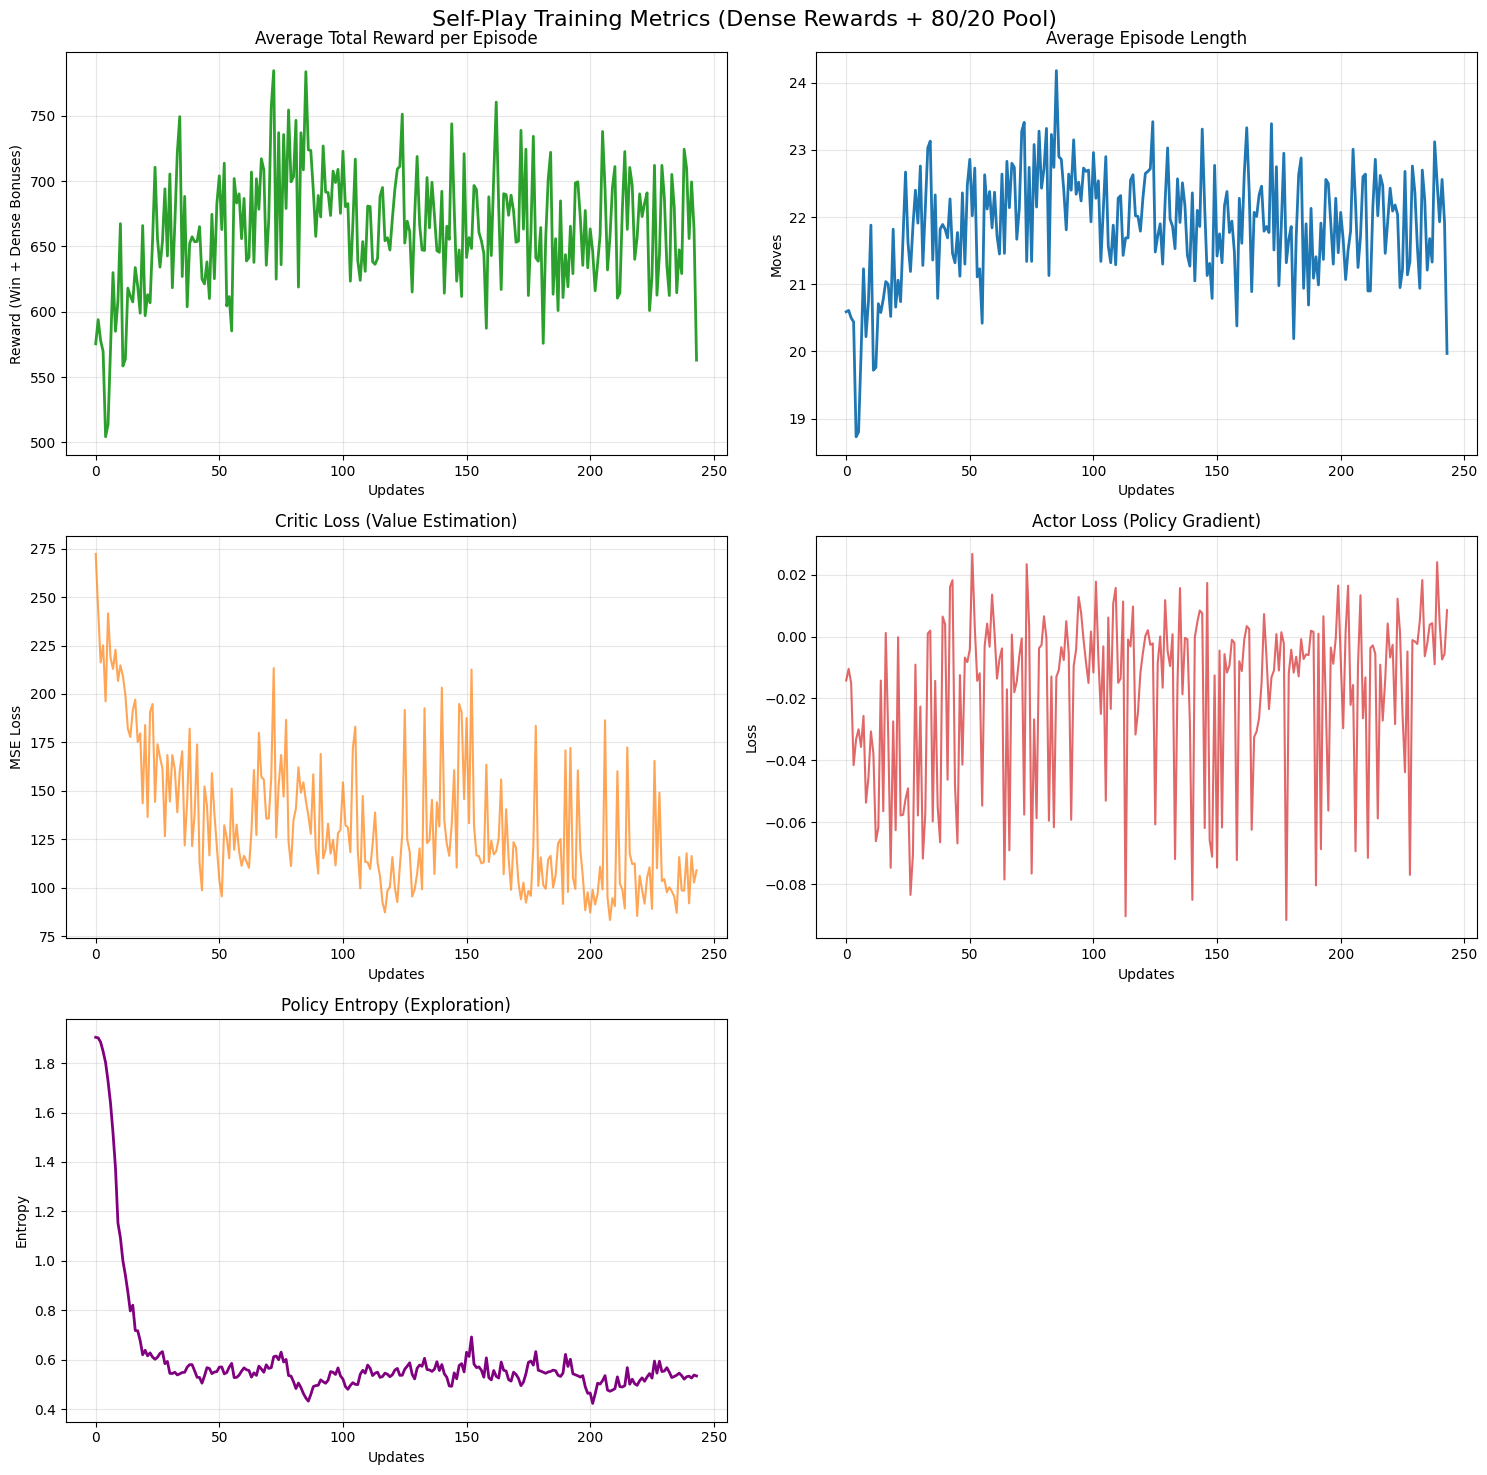

In [44]:
def plot_metrics(history):
    # Changed to 3 rows, 2 columns to fit Entropy
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle('Self-Play Training Metrics (Dense Rewards + 80/20 Pool)', fontsize=16)

    # 1. Average Reward
    # Note: With dense rewards, this can go above 1.0 or below -1.0
    axs[0, 0].plot(history['avg_reward'], color='#2ca02c', linewidth=2)
    axs[0, 0].set_title("Average Total Reward per Episode")
    axs[0, 0].set_ylabel("Reward (Win + Dense Bonuses)")
    axs[0, 0].set_xlabel("Updates")
    axs[0, 0].grid(True, alpha=0.3)

    # 2. Episode Length
    axs[0, 1].plot(history['avg_length'], color='#1f77b4', linewidth=2)
    axs[0, 1].set_title("Average Episode Length")
    axs[0, 1].set_ylabel("Moves")
    axs[0, 1].set_xlabel("Updates")
    axs[0, 1].grid(True, alpha=0.3)

    # 3. Value Loss
    axs[1, 0].plot(history['value_loss'], color='#ff7f0e', alpha=0.7)
    axs[1, 0].set_title("Critic Loss (Value Estimation)")
    axs[1, 0].set_ylabel("MSE Loss")
    axs[1, 0].set_xlabel("Updates")
    axs[1, 0].grid(True, alpha=0.3)

    # 4. Policy Loss
    axs[1, 1].plot(history['policy_loss'], color='#d62728', alpha=0.7)
    axs[1, 1].set_title("Actor Loss (Policy Gradient)")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].set_xlabel("Updates")
    axs[1, 1].grid(True, alpha=0.3)
    
    # 5. Entropy (NEW)
    # This checks if the agent is still exploring or has converged
    axs[2, 0].plot(history['entropy'], color='purple', linewidth=2)
    axs[2, 0].set_title("Policy Entropy (Exploration)")
    axs[2, 0].set_ylabel("Entropy")
    axs[2, 0].set_xlabel("Updates")
    axs[2, 0].grid(True, alpha=0.3)

    # Hide the empty 6th subplot
    axs[2, 1].axis('off')

    plt.tight_layout()
    plt.show()

plot_metrics(history)

In [39]:
import torch
import numpy as np
import random
from tqdm.notebook import tqdm

def evaluate_agent(agent, n_games=100):
    # 1. Initialize the Wrapped Environment
    # This wrapper returns obs as (3, 6, 7) Array, and mask in info['legal_moves']
    env = ConnectFourEnv() 
    agent.eval()

    wins = 0
    losses = 0
    draws = 0

    print(f"Starting Evaluation: Agent vs Random ({n_games} games)...")

    for i in range(n_games):
        # Reset returns (obs_array, info) due to your wrapper
        obs, info = env.reset()
        done = False

        # Env uses 0 and 1 for players.
        # Wrapper info['turn'] returns 1 or 2.
        # Let's map Agent to internal ID 0 or 1.
        agent_player_id = i % 2 
        
        while not done:
            # Check internal turn (0 or 1)
            current_turn = env.current_player
            
            # Wrapper puts mask in info
            legal_moves_mask = info['legal_moves']

            if current_turn == agent_player_id:
                # --- AGENT MOVE ---
                # Wrapper already returns (3, 6, 7). 
                # Just add Batch Dimension -> (1, 3, 6, 7)
                obs_tensor = torch.Tensor(obs).unsqueeze(0).to(device)
                mask_tensor = torch.Tensor(legal_moves_mask).unsqueeze(0).to(device)

                with torch.no_grad():
                    action, _, _, _ = agent.get_action_and_value(obs_tensor, action_mask=mask_tensor)
                    action = action.item()
            else:
                # --- RANDOM MOVE ---
                valid_cols = [c for c, val in enumerate(legal_moves_mask) if val == 1]
                if not valid_cols:
                    action = 0 
                else:
                    action = random.choice(valid_cols)

            # Step returns (obs, reward, term, trunc, info)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            if done:
                # Win Reward is 40.0 in BaseEnv
                if reward > 10.0:  
                    # The player who just moved won
                    if current_turn == agent_player_id:
                        wins += 1
                    else:
                        losses += 1
                
                # Illegal move is -30.0
                elif reward < 0:
                    if current_turn == agent_player_id:
                        losses += 1
                    else:
                        wins += 1
                
                else:
                    draws += 1

    print(f"Results over {n_games} games:")
    print(f"Wins: {wins} ({wins/n_games*100:.1f}%)")
    print(f"Losses: {losses} ({losses/n_games*100:.1f}%)")
    print(f"Draws: {draws} ({draws/n_games*100:.1f}%)")

    return wins, losses, draws

# Run Evaluation
evaluate_agent(trained_agent, n_games=100)

Starting Evaluation: Agent vs Random (100 games)...
Results over 100 games:
Wins: 70 (70.0%)
Losses: 30 (30.0%)
Draws: 0 (0.0%)


(70, 30, 0)

Agent (Red/1) vs Random (Yellow/2)


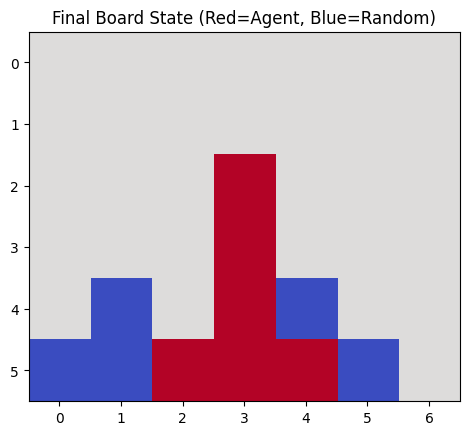

Winner: Agent


In [40]:
import matplotlib.pyplot as plt
import random

def play_demo_game(agent):
    # Use the Wrapper Env
    env = ConnectFourEnv()
    obs, info = env.reset()
    done = False
    
    # Internal IDs: Red=0, Yellow=1
    # Wrapper Info Turn: 1 or 2
    print('Agent (Red/1) vs Random (Yellow/2)')
    
    # Let Agent be Player 1 (Internal ID 0)
    agent_player_id = 0 
    
    last_actor_id = None
    
    while not done:
        # Wrapper provides mask and turn in info
        legal_mask = info['legal_moves']
        current_turn = env.current_player # 0 or 1
        
        if current_turn == agent_player_id:
            last_actor_id = 0
            # Wrapper obs is (3,6,7). Add batch dim -> (1,3,6,7)
            obs_tensor = torch.Tensor(obs).unsqueeze(0).to(device)
            mask_tensor = torch.Tensor(legal_mask).unsqueeze(0).to(device)
            
            with torch.no_grad():
                action, _, _, _ = agent.get_action_and_value(obs_tensor, action_mask=mask_tensor)
                action = action.item()
        else:
            last_actor_id = 1
            # Random Move
            valid_cols = [c for c, val in enumerate(legal_mask) if val == 1]
            action = random.choice(valid_cols) if valid_cols else 0
            
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

    # Visualization
    # BaseEnv board: 0=Empty, 1=P1, 2=P2
    board = env.board.copy().astype(int)
    
    # Convert for cmap: Red=-1, Yellow=1 (or adjust cmap)
    # Let's map: 0->0, 1->1(Red), 2->-1(Blue/Yellow) for 'coolwarm'
    board_vis = np.zeros_like(board)
    board_vis[board == 1] = 1  # Agent
    board_vis[board == 2] = -1 # Random
    
    plt.imshow(board_vis, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Final Board State (Red=Agent, Blue=Random)')
    # Note: Colorbar ticks might need adjustment based on mapping
    plt.grid(False)
    plt.show()
    
    # Win Reward is 40.0
    if reward > 10.0:
        winner = 'Agent' if last_actor_id == agent_player_id else 'Random'
        print(f'Winner: {winner}')
    elif reward < 0:
         # Illegal move by loser
         winner = 'Agent' if last_actor_id != agent_player_id else 'Random'
         print(f'Winner (via Disqualification): {winner}')
    else:
        print('Draw!')

play_demo_game(trained_agent)

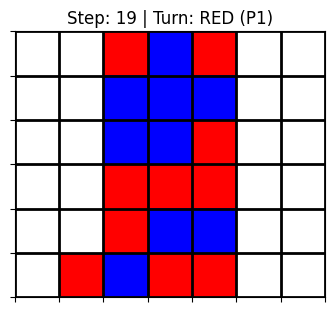

Game Over! Winner: RED


In [41]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time

def watch_self_play(agent, sleep_time=0.5):
    env = ConnectFourEnv()
    obs, info = env.reset()
    done = False
    agent.eval()
    
    fig, ax = plt.subplots(figsize=(4, 4))
    step_count = 0
    last_actor_id = None
    
    while not done:
        current_turn = env.current_player
        last_actor_id = current_turn
        
        # Wrapper obs: (3,6,7) -> (1,3,6,7)
        obs_tensor = torch.Tensor(obs).unsqueeze(0).to(device)
        mask_tensor = torch.Tensor(info['legal_moves']).unsqueeze(0).to(device)
        
        with torch.no_grad():
            action, _, _, _ = agent.get_action_and_value(obs_tensor, action_mask=mask_tensor)
            action = action.item()
            
        obs, reward, term, trunc, info = env.step(action)
        done = term or trunc
        step_count += 1
        
        # Render
        board = env.board.copy().astype(int)
        board_vis = np.zeros_like(board)
        board_vis[board == 1] = 1  # P1 (Red)
        board_vis[board == 2] = -1 # P2 (Blue)
        
        ax.clear()
        cmap = plt.cm.colors.ListedColormap(['blue', 'white', 'red'])
        bounds = [-1.5, -0.5, 0.5, 1.5]
        norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
        
        ax.imshow(board_vis, cmap=cmap, norm=norm)
        ax.grid(which='major', color='black', linestyle='-', linewidth=2)
        ax.set_xticks(np.arange(-.5, 7, 1))
        ax.set_yticks(np.arange(-.5, 6, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        turn_name = 'RED (P1)' if current_turn == 0 else 'BLUE (P2)'
        ax.set_title(f'Step: {step_count} | Turn: {turn_name}')
        
        clear_output(wait=True)
        display(fig)
        time.sleep(sleep_time)
        
    plt.close()
    
    if reward > 10.0:
        winner = 'RED' if last_actor_id == 0 else 'BLUE'
        print(f'Game Over! Winner: {winner}')
    elif reward < 0:
        winner = 'BLUE' if last_actor_id == 0 else 'RED'
        print(f'Game Over! Winner (Illegal Move): {winner}')
    else:
        print('Game Over! It\'s a DRAW.')

# Run the animation
watch_self_play(trained_agent, sleep_time=0.3)

In [42]:
def evaluate_self_play(agent, n_games=100):
    env = ConnectFourEnv()
    agent.eval()

    p1_wins = 0
    p2_wins = 0
    draws = 0

    print(f"Running {n_games} self-play games (Stochastic Mode)...")

    for i in range(n_games):
        obs, info = env.reset()
        done = False
        last_actor_id = None

        while not done:
            last_actor_id = env.current_player
            
            obs_tensor = torch.Tensor(obs).unsqueeze(0).to(device)
            mask_tensor = torch.Tensor(info['legal_moves']).unsqueeze(0).to(device)

            with torch.no_grad():
                # Stochastic
                action, _, _, _ = agent.get_action_and_value(obs_tensor, action_mask=mask_tensor)
                action = action.item()

            obs, reward, term, trunc, info = env.step(action)
            done = term or trunc

            if done:
                if reward > 10.0:
                    # Winner is the one who just moved
                    if last_actor_id == 0:
                        p1_wins += 1
                    else:
                        p2_wins += 1
                elif reward < 0:
                    # Loser is the one who just moved (illegal)
                    if last_actor_id == 0:
                        p2_wins += 1
                    else:
                        p1_wins += 1
                else:
                    draws += 1

    print("-" * 30)
    print(f"Self-Play Results ({n_games} Games):")
    print(f"Player 1 (Agent) Wins: {p1_wins} ({p1_wins/n_games*100:.1f}%)")
    print(f"Player 2 (Agent) Wins: {p2_wins} ({p2_wins/n_games*100:.1f}%)")
    print(f"Draws:                 {draws} ({draws/n_games*100:.1f}%)")
    print("-" * 30)
    
    if p1_wins > p2_wins + 200:
        print("Analysis: Strong First-Player Advantage detected.")
    elif abs(p1_wins - p2_wins) <= 200:
        print("Analysis: The agent is balanced.")
    else:
        print("Analysis: The agent plays better as Player 2.")

evaluate_self_play(trained_agent, n_games=1000)

Running 1000 self-play games (Stochastic Mode)...
------------------------------
Self-Play Results (1000 Games):
Player 1 (Agent) Wins: 629 (62.9%)
Player 2 (Agent) Wins: 361 (36.1%)
Draws:                 10 (1.0%)
------------------------------
Analysis: Strong First-Player Advantage detected.


In [45]:
class RandomAgent:
    def get_action(self, obs, info):
        legal_mask = info['legal_moves']
        valid_cols = [c for c, val in enumerate(legal_mask) if val == 1]
        if not valid_cols: return 0
        return random.choice(valid_cols)

def run_evaluation_metrics(agent, opponent_type="random", n_games=100):
    env = ConnectFourEnv()
    agent.eval()

    rewards, lengths = [], []
    outcomes = {"win": 0, "loss": 0, "draw": 0}

    opponent = RandomAgent() 
    print(f"Evaluating: PPO Agent vs {opponent_type.capitalize()} ({n_games} games)...")

    # Agent ID: 0 (Red) or 1 (Yellow)
    # We'll fix Agent as Player 0 for simplicity, or randomize?
    # Your logic had agent_player = 1. Let's adapt.
    
    for i in range(n_games):
        obs, info = env.reset()
        done = False
        steps = 0
        episode_reward = 0
        
        # Randomize start
        agent_player_id = i % 2 # 0 or 1
        last_actor_id = None

        while not done:
            steps += 1
            current_turn = env.current_player
            last_actor_id = current_turn
            
            legal_mask = info["legal_moves"]

            if current_turn == agent_player_id:
                # Agent Move
                obs_tensor = torch.Tensor(obs).unsqueeze(0).to(device)
                mask_tensor = torch.Tensor(legal_mask).unsqueeze(0).to(device)
                with torch.no_grad():
                    # Deterministic
                    action_idx, _, _, _ = agent.get_action_and_value(obs_tensor, action_mask=mask_tensor)
                    action = action_idx.item()
            else:
                # Random Move
                action = opponent.get_action(obs, info)

            obs, reward, term, trunc, info = env.step(action)
            done = term or trunc

        # Evaluate Outcome
        # Reward > 10.0 => Winner is last_actor_id
        # Reward < 0    => Loser is last_actor_id (Illegal)
        # Reward 0      => Draw
        
        final_result = 0 # 0=Draw, 1=Win, -1=Loss for Agent
        
        if reward > 10.0:
            if last_actor_id == agent_player_id:
                final_result = 1
                outcomes["win"] += 1
            else:
                final_result = -1
                outcomes["loss"] += 1
        elif reward < 0:
            if last_actor_id == agent_player_id:
                final_result = -1
                outcomes["loss"] += 1
            else:
                final_result = 1
                outcomes["win"] += 1
        else:
             outcomes["draw"] += 1

        rewards.append(final_result)
        lengths.append(steps)

    avg_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    avg_len = np.mean(lengths)
    win_rate = outcomes["win"] / n_games * 100
    
    results = {
        "avg_reward": avg_reward,
        "std_reward": std_reward,
        "avg_length": avg_len,
        "win_rate": win_rate,
        "outcomes": outcomes,
    }
    print(f"  > Average Reward: {avg_reward:.3f} +/- {std_reward:.3f}")
    print(f"  > Average Length: {avg_len:.1f} moves")
    print(f"  > Win Rate:       {win_rate:.1f}%")
    return results

# Run the standard evaluation
metrics = run_evaluation_metrics(trained_agent, "random", n_games=200)

Evaluating: PPO Agent vs Random (200 games)...
  > Average Reward: 0.400 +/- 0.917
  > Average Length: 16.7 moves
  > Win Rate:       70.0%
